<a href="https://colab.research.google.com/github/amcheyre-nw/image_mosaic_CV/blob/main/image_mosaic_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python-headless==4.1.2.30 -quiet


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import math
import os
from scipy import optimize

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
files_dir = '/content/drive/MyDrive/CV_Project/Input_images'

In [5]:
!pip install opencv-contrib-python==3.4.2.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Matching Features
### Generate SIFT features and establish correspondence between features of two images

In [6]:
class SiftKpDesc():
    def __init__(self, kp, desc):
        # List of keypoints in (x,y) crd -> N x 2
        self.kp = kp

        # List of Descriptors at keypoints : N x 128
        self.desc = desc

In [7]:
class SiftMatching:

    _BLUE = [255, 0, 0]
    _GREEN = [0, 255, 0]
    _RED = [0, 0, 255]
    _CYAN = [255, 255, 0]

    _line_thickness = 2
    _radius = 5
    _circ_thickness = 2


    def __init__(self, img_1_path, img_2_path, results_fldr='', nfeatures=2000, gamma=0.8):

        fname_1 = os.path.basename(img_1_path)
        fname_2 = os.path.basename(img_2_path)

        if not results_fldr:
            results_fldr = os.path.split(img_1_path)[0]

        self.result_fldr = os.path.join(results_fldr, 'results')

        self.prefix = fname_1.split('.')[0] + '_' + fname_2.split('.')[0]

        if not os.path.exists(self.result_fldr):
            os.makedirs(self.result_fldr)

        self.img_1_bgr = self.read_image(img_1_path)
        self.img_2_bgr = self.read_image(img_2_path)

        self.nfeatures = nfeatures
        self.gamma = gamma


    def read_image(self, img_path):

        img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)

        return img_bgr



    def get_sift_features(self, img_bgr, nfeatures=2000):

        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        sift_obj = cv2.xfeatures2d.SIFT_create(nfeatures)

        # kp_list_obj is a list of "KeyPoint" objects with location stored as tuple in "pt" attribute
        kp_list_obj, desc = sift_obj.detectAndCompute(image=img_gray, mask=None)

        kp = [x.pt for x in kp_list_obj]

        return SiftKpDesc(kp, desc)


    def match_features(self, sift_kp_desc_obj1, sift_kp_desc_obj2, gamma=0.8):
        correspondence = []  # list of lists of [x1, y1, x2, y2]

        for i in range(len(sift_kp_desc_obj1.kp)):
            sc = np.linalg.norm(sift_kp_desc_obj1.desc[i] - sift_kp_desc_obj2.desc, axis=1)
            idx = np.argsort(sc)

            val = sc[idx[0]] / sc[idx[1]]

            if val <= gamma:
                correspondence.append([*sift_kp_desc_obj1.kp[i], *sift_kp_desc_obj2.kp[idx[0]]])

        return correspondence


    def draw_correspondence(self, correspondence, img_1, img_2):

        if len(img_1.shape) == 2:
            img_1 = np.repeat(img_1[:, :, np.newaxis], 3, axis=2)

        if len(img_2.shape) == 2:
            img_2 = np.repeat(img_2[:, :, np.newaxis], 3, axis=2)

        h, w, _ = img_1.shape

        img_stack = np.hstack((img_1, img_2))

        for x1, y1, x2, y2 in correspondence:
            x1_d = int(round(x1))
            y1_d = int(round(y1))

            x2_d = int(round(x2) + w)
            y2_d = int(round(y2))

            cv2.circle(img_stack, (x1_d, y1_d), radius=self._radius, color=self._BLUE,
                       thickness=self._circ_thickness, lineType=cv2.LINE_AA)

            cv2.circle(img_stack, (x2_d, y2_d), radius=self._radius, color=self._BLUE,
                       thickness=self._circ_thickness, lineType=cv2.LINE_AA)

            cv2.line(img_stack, (x1_d, y1_d), (x2_d, y2_d), color=self._CYAN,
                     thickness=self._line_thickness)

        fname = os.path.join(self.result_fldr, self.prefix + '_sift_corr.jpg')
        cv2.imwrite(fname, img_stack)


    def run(self):

        sift_kp_desc_obj1 = self.get_sift_features(self.img_1_bgr, nfeatures=self.nfeatures)
        sift_kp_desc_obj2 = self.get_sift_features(self.img_2_bgr, nfeatures=self.nfeatures)

        correspondence = self.match_features(sift_kp_desc_obj1, sift_kp_desc_obj2, gamma=self.gamma)

        self.draw_correspondence(correspondence, self.img_1_bgr, self.img_2_bgr)

        return correspondence

In [8]:
# MAIN

img_1_path = "/content/drive/MyDrive/CV_Project/Input_images/Image_1/1.jpg"
img_2_path = "/content/drive/MyDrive/CV_Project/Input_images/Image_1/2.jpg"

siftmatch_obj = SiftMatching(img_1_path, img_2_path, results_fldr='', nfeatures=2000, gamma=0.6)
siftmatch_obj.run()

[[3014.82763671875, 2136.353759765625, 1547.49951171875, 2102.097412109375],
 [2179.279296875, 2234.656982421875, 740.7631225585938, 2195.707275390625],
 [3005.556396484375, 2122.7412109375, 1539.0728759765625, 2089.070068359375],
 [3003.5869140625, 1867.8837890625, 1539.95947265625, 1843.3404541015625],
 [2999.560791015625, 2136.116943359375, 1533.1021728515625, 2101.38916015625],
 [2999.560791015625, 2136.116943359375, 1533.1021728515625, 2101.38916015625],
 [2998.900634765625, 1873.7196044921875, 1536.3447265625, 1849.1700439453125],
 [2170.1474609375, 2042.9073486328125, 733.318115234375, 2004.8148193359375],
 [2998.64013671875, 2172.38623046875, 1532.7845458984375, 2136.5361328125],
 [2997.0869140625, 2206.0537109375, 1530.5157470703125, 2169.18603515625],
 [2987.512939453125,
  1874.2230224609375,
  1526.3509521484375,
  1849.353759765625],
 [2147.899169921875,
  2030.3966064453125,
  710.7640991210938,
  1991.9862060546875],
 [2196.5087890625, 2331.23779296875, 1180.972900390625

# 2. Homography
### Helper functions which help in bilinear interpolation and projecting images to a canvas using Homography matrix

In [9]:
def calculate_homography(in_pts, out_pts):
    """
    in_pts = H*out_pts
    :param in_pts: correspond to src
    :param out_pts:
    :return:
    """

    if isinstance(in_pts, list):
        in_pts = np.array(in_pts)

    if isinstance(out_pts, list):
        out_pts = np.array(out_pts)

    mat_A, mat_b = build_sys_equations(in_pts, out_pts)

    H = np.matmul(np.linalg.pinv(mat_A), mat_b)

    print(mat_b)
    
    print(np.matmul(mat_A, H))

    H = np.reshape(np.hstack((H,1)), (3,3))

    return H

In [10]:
def convert_to_homogenous_crd(inp, axis=1):

    if isinstance(inp, list):
        inp = np.array(inp)

    r, c = inp.shape

    if axis == 1:
        out = np.concatenate((inp, np.ones((r, 1))), axis=axis)
    else:
        out = np.concatenate((inp, np.ones((1, c))), axis=axis)

    return out

In [11]:
def get_pixel_coord(mask):
    """
    Function to get x, y coordinates of white pixels in mask as homogenous coordinates
    :param mask:
    :return:
    """
    y, x = np.where(mask)
    pts = np.concatenate((x[:,np.newaxis], y[:, np.newaxis], np.ones((x.size, 1))), axis=1) # rows of [x1, y1, 1]
    print(pts)

    return pts

In [12]:
def fit_image_in_target_space(img_src, img_dst, mask, H, offset=np.array([0, 0, 0])):
    """
    :param img_src: source image
    :param img_dst: destination image
    :param mask: mask corresponding to dest image
    :param H: pts_in_src_img = H * pts_in_dst_img
    :param offset: np array [x_offset, y_offset, 0]. Offset 0,0 in mask to this value
    :return:
    """

    pts = get_pixel_coord(mask)  # rows of [x1, y1, 1]

    pts = pts + offset

    out_src = np.matmul(H, pts.T)  # out_src has cols of [x1, y1, z1]

    out_src = out_src/out_src[-1,:]
    # print(out_src[-1,:])
    # print(out_src[:,0])

    # Return only x, y non-homogenous coordinates
    out_src = out_src[0:2, :]  # corresponds to pixels in img_src
    out_src = out_src.T  # rows of [x1, y1]

    # Convert pts to out_src convention
    pts = pts[:, 0:2].astype(np.int64)  # Corresponds to pixel locs in img_dst, rows of [x1,y1]

    h, w, _ = img_src.shape

    get_pixel_val(img_dst, img_src, pts, out_src, offset)

    # # x -> c  y -> r
    for i in range(out_src.shape[0]):
        if (0 <= out_src[i,0] < w-1) and (0 <= out_src[i,1] < h-1):
            img_dst[pts[i,1], pts[i,0], :] = get_pixel_val(out_src[i], img_src)


    return img_dst

In [13]:
def get_pixel_val(img_dst, img_src, pts, out_src, offset):
    """
    :param img_dst:
    :param pts: pts for img_dst rows of [x1, y1]
    :param out_src: rows of [x1, y1], corresponding pts in src img after homography on dst points
    :return:
    """
    h, w, _ = img_src.shape
    tl = np.floor(out_src[:, ::-1]).astype(np.int64) # reverse cols to get row, col notation
    br = np.ceil(out_src[:, ::-1]).astype(np.int64)

    pts = pts - offset[:2]

    r_lzero = np.where(~np.logical_or(np.any(tl < 0, axis=1), np.any(br < 0, axis=1)))
    pts = pts[r_lzero[0], :]
    out_src = out_src[r_lzero[0], :]
    tl = tl[r_lzero[0], :]
    br = br[r_lzero[0], :]

    r_fl = np.where(~np.logical_or(tl[:, 0] >= h-1, tl[:, 1] >= w-1))
    pts = pts[r_fl[0], :]
    out_src = out_src[r_fl[0], :]
    tl = tl[r_fl[0], :]
    br = br[r_fl[0], :]

    r_ce = np.where(~np.logical_or(br[:, 0] >= h-1, br[:, 1] >= w-1))
    pts = pts[r_ce[0], :]
    out_src = out_src[r_ce[0], :]
    tl = tl[r_ce[0], :]
    br = br[r_ce[0], :]

    print(pts.shape)
    print(out_src.shape)
    print(tl.shape)
    print(br.shape)

    tr = np.concatenate((tl[:, 0:1], br[:, 1:2]), axis=1)

    bl = np.concatenate((br[:, 0:1], tl[:, 1:2]), axis=1)

    weight = np.zeros((out_src.shape[0], 4))

    weight[:, 0] = np.linalg.norm(tl-out_src[:, ::-1], axis=1)
    weight[:, 1] = np.linalg.norm(tr-out_src[:, ::-1], axis=1)
    weight[:, 2] = np.linalg.norm(bl-out_src[:, ::-1], axis=1)
    weight[:, 3] = np.linalg.norm(br - out_src[:, ::-1], axis=1)

    weight[np.all(weight == 0, axis=1)] = 1  # For entries where they exactly overlap
    weight = 1/weight

    # pts = pts - offset[:2]

    img_dst[pts[:,1], pts[:,0], :] = (img_src[tl[:,0], tl[:,1], :] * weight[:, 0:1] + \
                                     img_src[tr[:,0], tr[:,1], :] * weight[:, 1:2] + \
                                     img_src[bl[:,0], bl[:,1], :] * weight[:, 2:3] + \
                                     img_src[br[:,0], br[:,1], :] * weight[:, 3:4])/ np.sum(weight, axis=1, keepdims=True)


    return img_dst

In [14]:
def build_sys_equations(in_pts, out_pts):
    """
    :param in_pts: nparray [[x1, y1], [x2, y2], ...]
    :param out_pts: nparray [[x1, y1], [x2, y2], ...]
    :param include_perp_bisector:
    :return:
    """

    mat_A = np.zeros((np.size(in_pts), 8))
    mat_b = in_pts.ravel()

    i = 0
    for x, y in out_pts:
        # x row
        mat_A[i][0:3] = [x, y, 1]
        mat_A[i][-2:] = [-x*mat_b[i], -y*mat_b[i]]

        # y row
        mat_A[i+1][-5:] = [x, y, 1, -x*mat_b[i+1], -y*mat_b[i+1]]

        # row counter
        i = i+2

    return mat_A, mat_b

In [16]:
def get_perp_bisectors(in_pts, out_pts):

    perp_in = np.array([in_pts[-1] + in_pts[0],
                        in_pts[0] + in_pts[1],
                        in_pts[1] + in_pts[2],
                        in_pts[2] + in_pts[3]])

    perp_out = np.array([out_pts[-1] + out_pts[0],
                         out_pts[0] + out_pts[1],
                         out_pts[1] + out_pts[2],
                         out_pts[2] + out_pts[3]])

    in_pts = np.concatenate((in_pts, perp_in / 2), axis=0)
    out_pts = np.concatenate((out_pts, perp_out / 2), axis=0)

    in_pts = in_pts.astype(np.int64)
    out_pts = out_pts.astype(np.int64)

    return in_pts, out_pts

In [17]:
def run_main(img_src_path, img_dst_path, out_pts, include_perp=False, save_fig='result.jpg'):
    """
    Fit img_src into img_dst. in_pts are in img_src, out_pts are in img_dst (clkwise starting from top left)
    :param img_1_path:
    :param img_2_path:
    :param in_pts: pts chosen in source image
    :param out_pts: corresponding pts chosen in destination image
    :return:
    """


    fldr, fname = os.path.split(img_src_path)
    _, fname = os.path.split(img_dst_path)

    res_dir = os.path.join(fldr, 'results')
    if not os.path.exists(res_dir):
        os.makedirs(res_dir)

    img_src = cv2.imread(img_src_path)
    
    figure = plt.figure(figsize=(25, 25))
    plot = figure.add_subplot(1, 4, 1)  
    plot.imshow(img_src)
    
    img_src = img_src.astype('uint8')

    #img_src = cv2.cvtColor(cv2.imread(img_src_path), cv2.COLOR_BGR2RGB)
    img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
    img_dst = cv2.cvtColor(cv2.imread(img_dst_path), cv2.COLOR_BGR2RGB)


    if isinstance(out_pts, list):
        out_pts = np.array(out_pts)

    h, w, _ = np.shape(img_src)
    in_pts = np.array([[0, 0], [w, 0], [w, h], [0, h]])

    # Get mask
    mask = np.zeros(img_dst.shape[0:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, out_pts, 255)
    plot_req_images(img_src, img_dst, mask, os.path.join(res_dir, 'visualize_' + fname))

    if include_perp:
        in_pts, out_pts = get_perp_bisectors(in_pts, out_pts)

    H = calculate_homography(in_pts, out_pts)

    ## Check if homography correctly calculated
    print('-------')
    t_one = np.ones((in_pts.shape[0],1))
    t_out_pts = np.concatenate((out_pts, t_one), axis=1)
    print('-------')
    x = np.matmul(H, t_out_pts.T)
    x = x/x[-1,:]
    print(x)
    print('-------')
    print(in_pts.T)

    print(cv2.findHomography(out_pts, in_pts))
    print('-------')
    print(H)

    out = fit_image_in_target_space(img_src, img_dst, mask, H)
    plt.figure()
    plt.imshow(out)
    plt.axis('off')
    plt.savefig(os.path.join(res_dir, 'result_' + fname))

    plt.show()

In [18]:
def plot_req_images(img_src, img_dst, mask, figName):

    plt.figure()
    plt.suptitle("To fit src_img to dest_img mask region")

    plt.subplot(2, 2, 1)
    plt.title("Source_image")
    plt.imshow(img_src)
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("Dest_image")
    plt.imshow(img_dst)
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
    plt.title("Mask")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(cv2.bitwise_and(img_dst, img_dst, mask=~mask))
    plt.title("Destination region in image")
    plt.axis('off')
    plt.savefig(figName)

    plt.show()

error: ignored

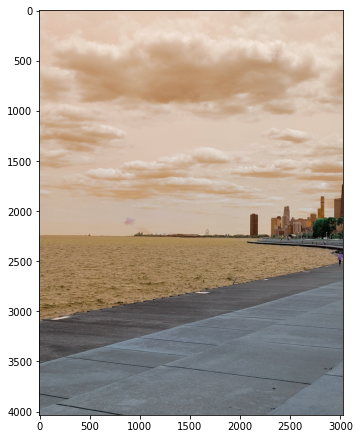

In [19]:
# MAIN

img_src_path = "/content/drive/MyDrive/CV_Project/Input_images/Image_1/1.jpg"
img_dst_path = '/content/drive/MyDrive/CV_Project/output_images/1.jpg'

out_pts = [[1518, 181], [2948, 731], [2997, 2046], [1490, 2227]]  #PQSR: Probabilistic Qualitative Spatial Relations

run_main(img_src_path, img_dst_path, out_pts, False)

######################
img_src_path = "/content/drive/MyDrive/CV_Project/Input_images/Image_1/2.jpg"
img_dst_path = '/content/drive/MyDrive/CV_Project/output_images/2.jpg'

out_pts = [[1331, 335], [3014, 621], [3030, 1892], [1309, 2007]]  # PQSR

run_main(img_src_path, img_dst_path, out_pts, False)
######################

img_src_path = "/content/drive/MyDrive/CV_Project/Input_images/Image_1/3.jpg"
img_dst_path = '/content/drive/MyDrive/CV_Project/output_images/3.jpg'

out_pts = [[929, 737], [2799, 390], [2849, 2222], [907, 2079]]  # PQSR

run_main(img_src_path, img_dst_path, out_pts, False)

# 3. RANSAC
### Random Sampling and Consensus, to get rid of outliers

In [20]:
class RANSAC:
    _BLUE = [255, 0, 0]
    _GREEN = [0, 255, 0]
    _RED = [0, 0, 255]
    _CYAN = [255, 255, 0]

    _line_thickness = 2
    _radius = 5
    _circ_thickness = 2

    def __init__(self, p=0.99, eps=0.6, n=6, delta=3):
        """
        :param correspondence: np array of [x1, y1, x2, y2] rows where (x1,y1) in img1 matches with (x2,y2) in img2
        :param p: probability that at least one of the N trials will be free of outliers
        :param eps: probability that a given datapoint is an outlier
        :param n: No of datapoints to be sampled per trial
        :param delta: Threshold to determine if a given datapoint is an inlier or outlier
        """
        self.n = n
        self.p = p
        self.eps = eps
        self.delta = delta
        self.N = self.compute_N(self.n, self.p, self.eps)


    def compute_N(self, n, p, eps):

        #N = ln(1-p)/ln(1-(1-eps)^n)
        # N is the number of trials such that atleast one trial is free of outliers

        N = np.round(np.log(1-p)/np.log(1-(1-eps)**n))
        return N


    def sample_n_datapts(self, n_total, n=6):
        """
        :param ntotal: total number of points
        :param n: no of sample correspondences to pick
        :return:
        """
        # id's indicating sampled n points
        idx = np.random.choice(n_total, n, replace=False)

        # id's of points not sampled
        n_idx = np.setdiff1d(np.arange(n_total), idx)

        return idx, n_idx


    def get_inliers(self, H, pts_in_expected, delta):
        """
        :param H: Transformation matrix expected_pts = H * in_pts
        :param pts_in_expected: rows of [x1, y1, x2, y2]
        :param delta: threshold between expected and computed points
        :return:
        """

        pts_in = pts_in_expected[:, 0:2]
        pts_expected = pts_in_expected[:, 2:]

        pts_in = convert_to_homogenous_crd(pts_in, axis=1)  # rows of [x1, y1, 1]

        est_pts = np.matmul(H, pts_in.T)  # cols of [x1, y1, z1]  est_pts = H*in_pts

        est_pts = est_pts/est_pts[-1, :]
        est_pts = est_pts.T  # Rows of [x1, y1, 1]

        dst = np.linalg.norm(est_pts[:, 0:2] - pts_expected, axis=1)

        inliers = pts_in_expected[np.where(dst <= delta)]

        outliers = pts_in_expected[np.where(dst > delta)]

        return inliers, outliers



    def run_ransac(self, correspondence):
        """
        :param correspondence: list of lists/ nd array of rows of x1, y1(in img1), x2, y2(in img2) where x2, y2 = H * x1, y1
        :return current_inliers_cnt : number of inlier correspondence
        :return  current_inliers : ndarray of [x1, y1 x2, y2] rows
        :return current_outliers : ndarray of [x1, y1 x2, y2] rows
        :return current_sample_pts: ndarray of [x1, y1 x2, y2] rows -> sample correspondence chosen during RANSAC
        :return final_H: 3x3 nd array of transformation matrix computed using inliers and sample points. x2, y2 = final_H * x1, y1
        """

        if isinstance(correspondence, list):
            correspondence = np.array(correspondence)

        # # Minimum number of inliers to be accepted as valid set
        n_total = correspondence.shape[0]
        self.M = (1-self.eps)*n_total

        print("N: {}, n: {}, M:{}, p: {}, eps: {}, delta: {}".format(self.N, self.n, self.M,
                                                                     self.p, self.eps, self.delta))
        no_iter = 0

        current_inliers = []
        current_inliers_cnt = 0

        current_sample_pts = []
        current_outliers = []

        while no_iter <= self.N:


            idx, n_idx = self.sample_n_datapts(n_total, self.n)

            sample_pts = correspondence[idx]
            other_pts = correspondence[n_idx]

            # in_pts = H*out_pts
            H = calculate_homography(in_pts=sample_pts[:, 2:], out_pts=sample_pts[:, 0:2])

            inliers, outliers = self.get_inliers(H, other_pts, delta=self.delta)

            inlier_count = inliers.shape[0]

            print("prev_inlier_cnt: {}, new_inlier_cnt: {}".
                  format(current_inliers_cnt, inlier_count))

            if (inlier_count > self.M) and (inlier_count > current_inliers_cnt):
                print(" #### Found better sample of points. Updating #####")
                current_inliers = inliers
                current_outliers = outliers
                current_inliers_cnt = inlier_count
                current_sample_pts = sample_pts

            print(" Done {}/{}".format(no_iter, self.N))

            no_iter += 1

        final_corr_points = np.concatenate((current_sample_pts, current_inliers), axis=0)
        final_H = calculate_homography(in_pts=final_corr_points[:, 2:],
                                                    out_pts=final_corr_points[:, 0:2])

        return current_inliers_cnt, current_inliers, current_outliers, current_sample_pts, final_H


    def draw_lines(self, corr_pts, img_1, img_2, save_path, line_color, pt_color):
        """
        Function to draw lines to indicate correspondence
        :param corr_pts: nd array of points from ing_1 to img2 [x1, y1, x2, y2] rows
        :param img_1: RGB ndarray for image 1
        :param img_2: RGB ndarray for image 2
        :param save_path: Full path to save result image
        :param line_color: color of line. 3 tuple RGB
        :param pt_color: color of point marking coorresponding points, 3 tuple of RGB
        :return:
        """

        h, w, _ = img_1.shape

        img_stack = np.hstack((img_1, img_2))

        for x1, y1, x2, y2 in corr_pts:
            x1_d = int(round(x1))
            y1_d = int(round(y1))

            x2_d = int(round(x2) + w)
            y2_d = int(round(y2))

            cv2.circle(img_stack, (x1_d, y1_d), radius=self._radius, color=pt_color,
                       thickness=self._circ_thickness, lineType=cv2.LINE_AA)

            cv2.circle(img_stack, (x2_d, y2_d), radius=self._radius, color=pt_color,
                       thickness=self._circ_thickness, lineType=cv2.LINE_AA)

            cv2.line(img_stack, (x1_d, y1_d), (x2_d, y2_d), color=line_color,
                     thickness=self._line_thickness)

        cv2.imwrite(save_path, img_stack)

# 4. Optimizer
### Refine the Homography estimate using Levenberg- Marquardt optimization

In [21]:
class OptimizeResult():
    # Result object from an optimization method
    def __init__(self, x=0, nint=0, success=True, message='', min_cost=0):
        """
        :param x: ndarray : The solution of the optimization
        :param nint: int : Number of iterations performed by the optimizer.
        :param success: bool: Whether or not the optimizer exited successfully.
        :param message: str : Description of the cause of the termination
        :param min_cost: float : Cost evaluated at x (solution to optimization)
        """
        self.x = x
        self.nint = nint
        self.success = success
        self.message = message
        self.min_cost = min_cost

    def __repr__(self):
        out = "######## \n solution x: {}\n No of iterations : {} \n Success: {} \n Message : {} \n Min Cost: {} \n ########".\
            format(self.x, self.nint, self.success, self.message, self.min_cost)

        return out

In [22]:
class OptimizeFunction:
    """
    Class with optimization function suite. Returns an output object of "OptimizeResult" class
    """
    def __init__(self, fun, x0, jac, args=()):
        """
        :param fun: function handle to vector to minimize in Non Linear least square sense. Takes input and args
        :param x0: initial guess
        :param jac: Function to return jacobian of fun. Takes same inputs as fun
        :param args: additional args to be passed to fun and jacobian
        :param kwargs: keyword args to be passed to the methods. kwargs such as thresholds etc
        :return result: OptimizeResult class object
        """

        self.result = OptimizeResult(x=x0, nint=0, success=True, message="Initialization", min_cost=0)
        self.x0 = x0
        self.args = args
        self.fun = fun
        self.jac = jac


    def levenberg_marquardt(self, delta_thresh=10**-16, tau=0.5):

        init_jac_f = self.jac(self.x0, *self.args)

        # Compute mu_0
        mu_k = tau * np.amax(np.diag(init_jac_f))

        # initialize
        xk = self.x0

        # iteration counter
        iter = 0

        # update_iter
        update_iter = 0

        # Compute initial residual, cost and result object to reflect initialization
        residual_k = self.fun(xk, *self.args)
        cost_k = np.dot(residual_k.T, residual_k)

        self.result.update_iter = update_iter
        self.result.min_cost = cost_k

        while True:

            # Compute Jacobian of residual
            jac_f = self.jac(xk, *self.args)

            # Compute next delta
            delta_k = np.dot(jac_f.T, jac_f) + mu_k * np.eye(jac_f.shape[1], jac_f.shape[1])  #[Jf_T * Jf + mu*I]
            delta_k = np.linalg.inv(delta_k)  #[Jf_T * Jf + mu*I]^-1
            delta_k = np.dot(delta_k, -1*jac_f.T)
            delta_k = np.dot(delta_k, residual_k)

            # If next update step is less than the threshold, then return
            if np.linalg.norm(delta_k) < delta_thresh or (update_iter > 100):
            # if update_iter > 50:
                self.result.x = xk
                self.result.nint = iter
                self.result.update_iter = update_iter
                self.result.message = '||Delta_k|| < {}'.format(delta_thresh)
                self.result.success = True
                self.result.min_cost = cost_k
                return self.result

            # Compute xk+1
            xk_1 = xk + delta_k

            # Compute eps at xk+1
            residual_k_1 = self.fun(xk_1, *self.args)

            # Compute cost at xk+1
            cost_k_1 = np.dot(residual_k_1.T, residual_k_1)

            # Calculate rho_LM
            num = (cost_k - cost_k_1)
            den = np.dot(np.dot(delta_k.T, -1*jac_f.T), residual_k)
            den = den + np.dot(np.dot(delta_k.T, mu_k * np.eye(jac_f.shape[1], jac_f.shape[1])), delta_k)
            rho_LM = num/den

            # compute mu_k+1
            mu_k = mu_k * max(1/3, 1 - (2 * rho_LM - 1)**3)


            # Update xk to xk+1 only if cost reduces
            if cost_k_1 < cost_k:
                # print("cost_k:{}, cost_k+1: {}".format(cost_k, cost_k_1))

                xk = xk_1
                update_iter += 1
                residual_k = residual_k_1
                cost_k = cost_k_1


            iter += 1


    def dogleg(self):
        pass

    def gauss_newton(self):
        pass

    def gradient_descent(self):
        pass

In [23]:
######## Function for "fun" and "jac" solely for Homography #######
### Use as sample to use LM optimization  ####

def fun_LM_homography(h, x, x_dash):
    """
    Function to pass to OptimizeFunction
    :param h: Vector to be optimized
    :param x: physical coordinates - ndarray of rows of [x1, y1] such that x_dash(in homoogenous crd) = H * x(in homoogenous crd)
    :param x_dash: physical cooordinates - ndarray of rows of x1 y1
    :return:
    """

    H = np.reshape(h, (3,3))

    x_tild = convert_to_homogenous_crd(x, axis=1)  #rows of [x1, y1, 1]
    x_tild = np.dot(H, x_tild.T)
    x_tild = x_tild/x_tild[-1, :]
    x_tild = x_tild.T  # rows of x, y, 1
    x_tild = x_tild[:, 0:2]

    residual = x_dash.flatten() - x_tild.flatten()  # [x`1, y`1, x`2, y`2] - [f11, f21, f12, f22] -> to be optimized by Least squares

    return residual

In [24]:
def jac_LM_homography(h, x, x_dash):

    def jac_fun1(inp_x, inp_h):
        # h = [h11, h12, h13, h21, h22, h23, h31, h32, h33]
        # x = [x1,y1]
        num = inp_h[0] * inp_x[0] + inp_h[1] * inp_x[1] + inp_h[2]
        den = inp_h[6] * inp_x[0] + inp_h[7] * inp_x[1] + inp_h[8]

        # computing deps/dh11 ....deps/dh33
        out = np.zeros_like(inp_h)
        out[0] = -1 * inp_x[0]/den  # deps/dh11
        out[1] = -1 * inp_x[1]/den  #deps/dh12
        out[2] = -1/den  # deps/dh13
        out[6] = (num * inp_x[0])/(den**2)  # deps/dh31
        out[7] = (num * inp_x[1])/(den**2)  #deps/dh32
        out[8] = num/(den**2)  #deps/dh33

        return out

    def jac_fun2(inp_x, inp_h):
        # h = [h11, h12, h13, h21, h22, h23, h31, h32, h33]
        # x = [x1,y1]
        num = inp_h[3] * inp_x[0] + inp_h[4] * inp_x[1] + inp_h[5]
        den = inp_h[6] * inp_x[0] + inp_h[7] * inp_x[1] + inp_h[8]

        # computing deps/dh11 ....deps/dh33
        out = np.zeros_like(inp_h)
        out[3] = -1 * inp_x[0] / den  # deps/dh11
        out[4] = -1 * inp_x[1] / den  # deps/dh12
        out[5] = -1 / den  # deps/dh13
        out[6] = (num * inp_x[0])/(den ** 2)  # deps/dh31
        out[7] = (num * inp_x[1])/(den ** 2)  # deps/dh32
        out[8] = num/(den ** 2)  # deps/dh33

        return out

    jac_eps_1 = np.apply_along_axis(jac_fun1, 1, x, h)
    jac_eps_2 = np.apply_along_axis(jac_fun2, 1, x, h)


    jac_out = np.empty((jac_eps_1.shape[0] + jac_eps_2.shape[0], jac_eps_1.shape[1]))
    jac_out[0::2] = jac_eps_1
    jac_out[1::2] = jac_eps_2

    return jac_out

In [25]:
def func(x):
    return np.array([x[0] + 0.5 * (x[0] - x[1])**3 - 1.0,
            0.5 * (x[1] - x[0])**3 + x[1]])

In [26]:
def jac(x):
    return np.array([[1 + 1.5 * (x[0] - x[1])**2,
                      -1.5 * (x[0] - x[1])**2],
                     [-1.5 * (x[1] - x[0])**2,
                      1 + 1.5 * (x[1] - x[0])**2]])

In [27]:
# MAIN


sol = optimize.least_squares(func, [0, 0], jac=jac, method='lm')
print(sol)
print("-----")


opt_obj = OptimizeFunction(fun=func, x0=np.array([0,0]), jac=jac)
LM_sol = opt_obj.levenberg_marquardt(delta_thresh=1e-6, tau=0.8)
print(LM_sol)

# Testing if the solution from scipy and this function are the same
x_img1 = np.random.randint(20, 50, size=(20, 2))
H = np.arange(1, 10).reshape(3,3)

x_temp = convert_to_homogenous_crd(x_img1, axis=1)
x_tild = np.dot(H, x_temp.T)
x_tild = x_tild / x_tild[-1, :]
x_tild = x_tild.T
x_img2 = x_tild[:, 0:2]

x_inp = np.concatenate((x_img1, x_img2), axis=1)

H_noise = H + np.random.randn(3, 3) + 10

opt_obj = OptimizeFunction(fun=fun_LM_homography, x0=H_noise.flatten(), jac=jac_LM_homography,
                            args=(x_inp[:, 0:2], x_inp[:, 2:]))
LM_sol = opt_obj.levenberg_marquardt(delta_thresh=1e-24, tau=0.8)

print("LM_sol : {}, \n &&&& {} &&&&".format(LM_sol, LM_sol.x/LM_sol.x[-1]))

print("=========")

sol = optimize.least_squares(fun_LM_homography, H_noise.flatten(), args=(x_inp[:, 0:2], x_inp[:, 2:]), method='lm',
                              jac=jac_LM_homography,
                              xtol=1e-24, ftol=1e-24)
print("scipy sol: \n &&& {}  &&&&".format(sol, sol.x/sol.x[-1]))

print("=========")

print("Original : {}".format(H/H[-1, -1]))

 active_mask: array([0, 0])
        cost: 6.548161810916602e-33
         fun: array([-1.11022302e-16,  2.77555756e-17])
        grad: array([-2.07938784e-16,  1.24672057e-16])
         jac: array([[ 1.69835685, -0.69835685],
       [-0.69835685,  1.69835685]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 7
        njev: 6
  optimality: 2.0793878394364416e-16
      status: 3
     success: True
           x: array([0.8411639, 0.1588361])
-----
######## 
 solution x: [0.8411639  0.15883609]
 No of iterations : 6 
 Success: True 
 Message : ||Delta_k|| < 1e-06 
 Min Cost: 2.487836869293475e-17 
 ########
LM_sol : ######## 
 solution x: [ 2.7989381   5.59787621  8.39681431 11.19575242 13.99469052 16.79362863
 19.59256673 22.39150484 25.19044294]
 No of iterations : 64 
 Success: True 
 Message : ||Delta_k|| < 1e-24 
 Min Cost: 8.474091755303838e-32 
 ########, 
 &&&& [0.11111111 0.22222222 0.33333333 0.44444444 0.55555556 0.66666667
 0.77777778 0.88888889 1.     

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_lsq/least_squares.py:115: UserWarning: Setting `ftol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  .format(name, EPS))
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_lsq/least_squares.py:115: UserWarning: Setting `xtol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  .format(name, EPS))


KeyError: ignored

# 5. Generate Mosaic

In [ ]:
class GenerateMosaic:

    def __init__(self, parent_folder, img_name_list):
        self.img_all = {}
        self.parent_folder = parent_folder
        self.img_name_list = img_name_list
        self.middle_id = int(np.floor(len(img_name_list)/2))

        # # Read all images and store in dictionary
        # for id, img_name in enumerate(img_name_list):
        #     img_path = os.path.join(parent_fldr, img_name)
        #     self.img_all[id+1] = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)



    def mosaic(self):

        H_all = {}
        for i in range(len(self.img_name_list) - 1):
            print(" #### Processing {} & {} ######".format(self.img_name_list[i], self.img_name_list[i + 1]))


            key = 'H{}{}'.format(i, i+1)

            img_1_path = os.path.join(self.parent_folder, self.img_name_list[i])
            img_2_path = os.path.join(self.parent_folder, self.img_name_list[i + 1])

            # Get SIFT descriptors
            siftmatch_obj = SiftMatching(img_1_path, img_2_path, results_fldr='', nfeatures=2000, gamma=0.6)
            correspondence = siftmatch_obj.run()

            # Run RANSAC to remove outliers
            ransac_obj = RANSAC()
            inliers_cnt, inliers, outliers, sample_pts, final_H = ransac_obj.run_ransac(correspondence)

            result_path = os.path.join(siftmatch_obj.result_fldr, siftmatch_obj.prefix + '_inliers.jpg')
            ransac_obj.draw_lines(np.concatenate((inliers, sample_pts), axis=0), siftmatch_obj.img_1_bgr,
                                  siftmatch_obj.img_2_bgr, result_path,
                                  line_color=RANSAC._GREEN, pt_color=[0, 0, 0])

            result_path = os.path.join(siftmatch_obj.result_fldr, siftmatch_obj.prefix + 'outliers.jpg')
            ransac_obj.draw_lines(outliers, siftmatch_obj.img_1_bgr, siftmatch_obj.img_2_bgr, result_path,
                                  line_color=RANSAC._RED, pt_color=[0, 0, 0])

            # Optimize the homography using Levenberg-Marquardt optimization
            x = np.concatenate((inliers, sample_pts), axis=0)
            opt_obj = OptimizeFunction(fun=fun_LM_homography, x0=final_H.flatten(), jac=jac_LM_homography,
                                       args=(x[:, 0:2], x[:, 2:]))
            LM_sol = opt_obj.levenberg_marquardt(delta_thresh=1e-24, tau=0.8)

            H_all[key] = LM_sol.x.reshape(3, 3)
            H_all[key] = H_all[key] / H_all[key][-1, -1]


            # sol = optimize.least_squares(fun_LM_homography, final_H.flatten(), args=(x[:, 0:2], x[:, 2:]), method='lm', jac=jac_LM_homography,
            #                              xtol=1e-24, ftol=1e-24)
            #                     # options={'xtol':1e-24})
            # res = fun_LM_homography(sol.x, *(x[:, 0:2], x[:, 2:]))
            # cost_sc = np.dot(res.T, res)

            # print("scipy solution: {}, {}, status:{}, cost={}".format(sol.x, sol.message, sol.status, cost_sc))
            # print('==============')
            # print("LM_sol: {}, {}, update_iter:{}, cnt: {}, cost: {}".format(LM_sol.x, LM_sol.message, LM_sol.update_iter, LM_sol.nint, LM_sol.min_cost))
            # print('==============')
            # print("initial val : {}".format(final_H.flatten()))

            # Hij -> pts_in_img_j = Hij * pts_in_img_i

        H_all = self.compute_H_wrt_middle_img(H_all)

        self.stitch(H_all, siftmatch_obj.result_fldr)






    def stitch(self, H_all, result_fldr):

        canvas_img, mask, offset = self.get_blank_canvas(H_all)

        for i, img_name in enumerate(self.img_name_list):

            key = "H{}{}".format(i, self.middle_id)
            H = H_all[key]
            img_path = os.path.join(self.parent_folder, img_name)

            img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

            canvas_img = fit_image_in_target_space(img_rgb, canvas_img, mask, np.linalg.inv(H),
                                                   offset=offset)  # the inp to fit_image_in_target_space
            # pts_in_img_2 = H * pts_in_canvas
            mask[np.where(canvas_img)[0:2]] = 0

            result_path = os.path.join(result_fldr, 'panorama_{}.jpg'.format(i))
            cv2.imwrite(result_path, canvas_img[:, :, (2, 1, 0)])









    def get_blank_canvas(self, H_all):

        img_path = os.path.join(self.parent_folder, self.img_name_list[0])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        img_h, img_w, _ = img.shape

        min_crd_canvas = np.array([np.inf, np.inf, np.inf])
        max_crd_canvas = np.array([-np.inf, -np.inf, -np.inf])



        for i in range(len(self.img_name_list)):
            key = "H{}{}".format(i, self.middle_id)
            H = H_all[key]
            min_crd, max_crd = self.compute_extent(H, img_w, img_h)

            min_crd_canvas = np.minimum(min_crd, min_crd_canvas)
            max_crd_canvas = np.maximum(max_crd, max_crd_canvas)

        width_canvas = np.ceil(max_crd_canvas - min_crd_canvas)[0] + 1
        height_canvas = np.ceil(max_crd_canvas - min_crd_canvas)[1] + 1

        canvas_img = np.zeros((int(height_canvas), int(width_canvas), 3), dtype=np.int64)

        offset = min_crd_canvas.astype(np.int64)
        offset[2] = 0  # [x_offset, y_offset, 0]

        mask = np.ones((int(height_canvas), int(width_canvas)))

        return canvas_img, mask, offset







    def compute_extent(self, H, img_w, img_h):

        corners_img = np.array([[0, 0], [img_w, 0], [img_w, img_h], [0, img_h]])

        t_one = np.ones((corners_img.shape[0], 1))
        t_out_pts = np.concatenate((corners_img, t_one), axis=1)
        canvas_crd_corners = np.matmul(H, t_out_pts.T)
        canvas_crd_corners = canvas_crd_corners / canvas_crd_corners[-1, :]  # cols of [x1, y1, z1]

        min_crd = np.amin(canvas_crd_corners.T, axis=0)  # [x, y, z]
        max_crd= np.amax(canvas_crd_corners.T, axis=0)
        return min_crd, max_crd


    def compute_H_wrt_middle_img(self, H_all):


        # Hij is pts_in_img_j = Hij * pts_in_img_i
        # If num of images are 5, we have H01, H12, H23, H34 i.e
        # Pts_in_img_1 = H01 * pts_in_img_0
        # Pts_in_img_2 = H12 * pts_in_img_1
        # Pts_in_img_3 = H23 * pts_in_img_2
        # Pts_in_img_4 = H34 * pts_in_img_3

        # We need all the matrices wrt to the middle image frame of reference i.e H02, H12, H32, H42, H22

        # H02 = H12 * H01
        # H12 = H12


        num_imgs = len(H_all)+1

        key = "H{}{}".format(self.middle_id, self.middle_id)
        H_all[key] = np.eye(3)

        for i in range(0, self.middle_id):
            key = "H{}{}".format(i, self.middle_id)  # H02
            j = i
            temp = np.eye(3)
            while j < self.middle_id:
                key_t = "H{}{}".format(j, j+1)
                temp = np.matmul(H_all[key_t], temp)
                j += 1

            H_all[key] = temp


        # H32 = inv(H23)
        # H42 = inv(H23) * inv(H34)
        for i in range(self.middle_id+1, num_imgs):
            key = "H{}{}".format(i, self.middle_id)  # H32

            temp = np.eye(3)

            j = i-1

            while j >= self.middle_id:
                key_t = "H{}{}".format(j, j+1)
                temp = np.matmul(np.linalg.inv(H_all[key_t]), temp)
                j -= 1

            H_all[key] = temp


        return H_all